**W207_3 machine learning Final group Rossman competition Forecast sales using store, promotion, and competitor data**
Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.
In their first Kaggle competition, Rossmann is challenging you to predict 6 weeks of daily sales for 1,115 stores located across Germany. Reliable sales forecasts enable store managers to create effective staff schedules that increase productivity and motivation. By helping Rossmann create a robust prediction model, you will help store managers stay focused on what’s most important to them: their customers and their teams!
If you are interested in joining Rossmann at their headquarters near Hanover, Germany, please contact Mr. Frank König (Frank.Koenig {at} rossmann.de) Rossmann is currently recruiting data scientists at senior and entry-level positions.
https://www.kaggle.com/c/rossmann-store-sales
Started: 12:02 pm, Wednesday 30 September 2015 UTC Ends: 11:59 pm, Monday 14 December 2015 UTC (75 total days) Points: this competition awards standard ranking points Tiers: this competition counts towards tiers

In [89]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.dates
import matplotlib.cm as cm

import seaborn as sns
sns.set_style('whitegrid')

from datetime import datetime

import pandas as pd
from pandas import Series,DataFrame

import random
import numpy as np
import graphviz as gv
import csv
from scipy import sparse
import time

from sklearn import preprocessing
from sklearn.cross_validation import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import linear_model
from sklearn import naive_bayes

In [91]:
# functions

def quantLevel(df, ColNameLs=['Open', 'StateHoliday', 'SchoolHoliday', 'Promo']):
    # Display percentage of unique values of these fields
    for col in ColNameLs:
        sizes = df.groupby(col).size()
        print sizes / sizes.sum()
        print
    
def rmspe(y, yhat):
    y = y.astype('float')
    yhat = yhat.astype('float')
    inner = ((y-yhat)/y)**2
    return (np.mean(inner))**0.5


def convertColToCategory(data, colName, knownCategories):
    data.loc[:, colName] = data.loc[:, colName].astype('category', categories=knownCategories)

def transformData(inputData):
    data = inputData.copy()
    # StateHoliday have values of both '0' and 0.  Change all 0 to '0'
    data.loc[data['StateHoliday'] == 0, ('StateHoliday')] = '0'
    # Can consider:
    # Add a "IsDec" col
    # Convert categorical columns to category type
    convertColToCategory(data, 'DayOfWeek', list(range(1, 8)))
    convertColToCategory(data, 'Promo', list(range(2)))
    convertColToCategory(data, 'SchoolHoliday', list(range(2)))
    convertColToCategory(data, 'StateHoliday', list('0abc'))    
    
    if 'StoreType' in data.columns:
        convertColToCategory(data, 'StoreType', list('abcd'))
                         
    if 'Assortment' in data.columns:
        convertColToCategory(data, 'Assortment', list('abc'))

    return pd.get_dummies(data)


def trainModels(n_cutoff_months):
    all_y = []
    all_yhat = []
    lms = {}
    
    test_cutoff_date = train_data.index.max() - pd.DateOffset(months = n_cutoff_months)

    train_set = train_data[train_data.index <= test_cutoff_date]
    dev_set = train_data[train_data.index > test_cutoff_date]
    print "train_set size:", len(train_set)
    print "dev_set size:", len(dev_set)

    train_set_grouped = train_set.groupby('Store')
    dev_set_grouped = dev_set.groupby('Store')
    cols = None

    for group in train_set_grouped.groups.keys():
        x_drop_cols = ['Store', 'Sales', 'Customers', 'Open']

        train_X = train_set_grouped.get_group(group).drop(x_drop_cols, axis=1, inplace=False)
        train_y = train_set_grouped.get_group(group)['Sales']

        dev_X = dev_set_grouped.get_group(group).drop(x_drop_cols, axis=1, inplace=False)
        dev_y = dev_set_grouped.get_group(group)['Sales']

        # One model per store
        lm = linear_model.LinearRegression()
        lm.fit(X=train_X, y=train_y)
        lms[group] = lm
        yhat = lm.predict(dev_X)

        all_y.extend(dev_y.tolist())
        all_yhat.extend(yhat.tolist())
        
    print "Training model - dev data RMSPE=", RMSPE(np.array(all_y), np.array(all_yhat))
    return lms


def littleTest():
    # Test prediction using some input generated from training data
    random_idx = random.sample(train_df.index.tolist(), 100)

    try_df = train_df.loc[random_idx]
    try_y = try_df['Sales']
    try_df.drop(['Sales', 'Customers'], axis=1, inplace=True)
    try_df["Id"] = range(1, len(try_df) + 1)
    try_data = transformData(pd.merge(try_df, store_df.ix[:,['StoreType', 'Assortment', 'Store']], on='Store'))

    result = makePredictions(try_data)
    try_yhat = np.array([r[1] for r in result])

    print rmspe(try_y, try_yhat)
    
def BoxPlotGroupBy(data, y, group, axis):
    ax = sns.boxplot(data[y], groupby = data[group], 
                     order = np.sort(pd.unique(data[group])), ax = axis)
    txt = ax.set_title(y + " grouped by " + group) 
    if axis is None:
        plt.show()
    
    
    

## data wrangle

In [32]:
train_data = pd.read_csv('train.csv') #~/Development/kaggle/rossman/data/
test_data = pd.read_csv('test.csv') #~/Development/kaggle/rossman/data/
store_data = pd.read_csv('store.csv') #~/Development/kaggle/rossman/data/

In [33]:
# Fixing column 7 errors it by change all 0 to '0'
train_data.loc[train_data['StateHoliday'] == 0, 'StateHoliday'] = '0'

# Convert the date column in train and test data
train_data['Date'] = pd.to_datetime(train_data['Date'], format="%Y-%m-%d")
test_data['Date'] = pd.to_datetime(test_data['Date'], format="%Y-%m-%d")

# Closed stores are dont sell anything. Closed stores comprise ~15% of the test set. 
# According to the board closed store predictions do not count toward the score.

#> closed=train_data[train_data['Open']==0]
#> quantLevel(closed, ['Sales'])
#> quantLevel(test_data, ['Open'])

#Keep only records where the store is open
train_data = train_data.loc[train_data['Open'] == 1]
test_data = test_data.loc[test_data['Open'] == 1]


# Keep only records with non-zero sales
train_data = train_data.loc[train_data['Sales'] > 0]
train_data = train_data.loc[train_data['Sales'] > 0]

# remove open since it is not used
test_data.drop('Open', axis=1, inplace='true')
train_data.drop('Open', axis=1, inplace='true')

In [95]:
#For each store, convert it's competitor open day into a Date column
competitorOpenDay = store_data.apply(lambda row: np.nan 
        if pd.isnull(row['CompetitionOpenSinceMonth']) or pd.isnull(row['CompetitionOpenSinceYear'])
        else np.datetime64("%d-%02d-01" % (int(row['CompetitionOpenSinceYear']), int(row['CompetitionOpenSinceMonth']))), 
        axis=1)

store_data["CompetitorOpenDay"] = competitorOpenDay


# For those stores with empty CompetitorOpenDay date, set it to the same as StoreOpenDay
store_data.ix[:, 'CompetitorOpenDay'] = store_data["CompetitorOpenDay"].fillna(store_data['OpenDay'])
#store_df.ix[:,['CompetitorOpenDay', 'OpenDay']]


## 1- Feature exploration and enginering 
Add suggested features with justification

## some of these stores do much better than others ##
* that is evident from differences in the slope of the lines for this sample set
I think we should include slope of historical customer x sales relation when making predictions * 


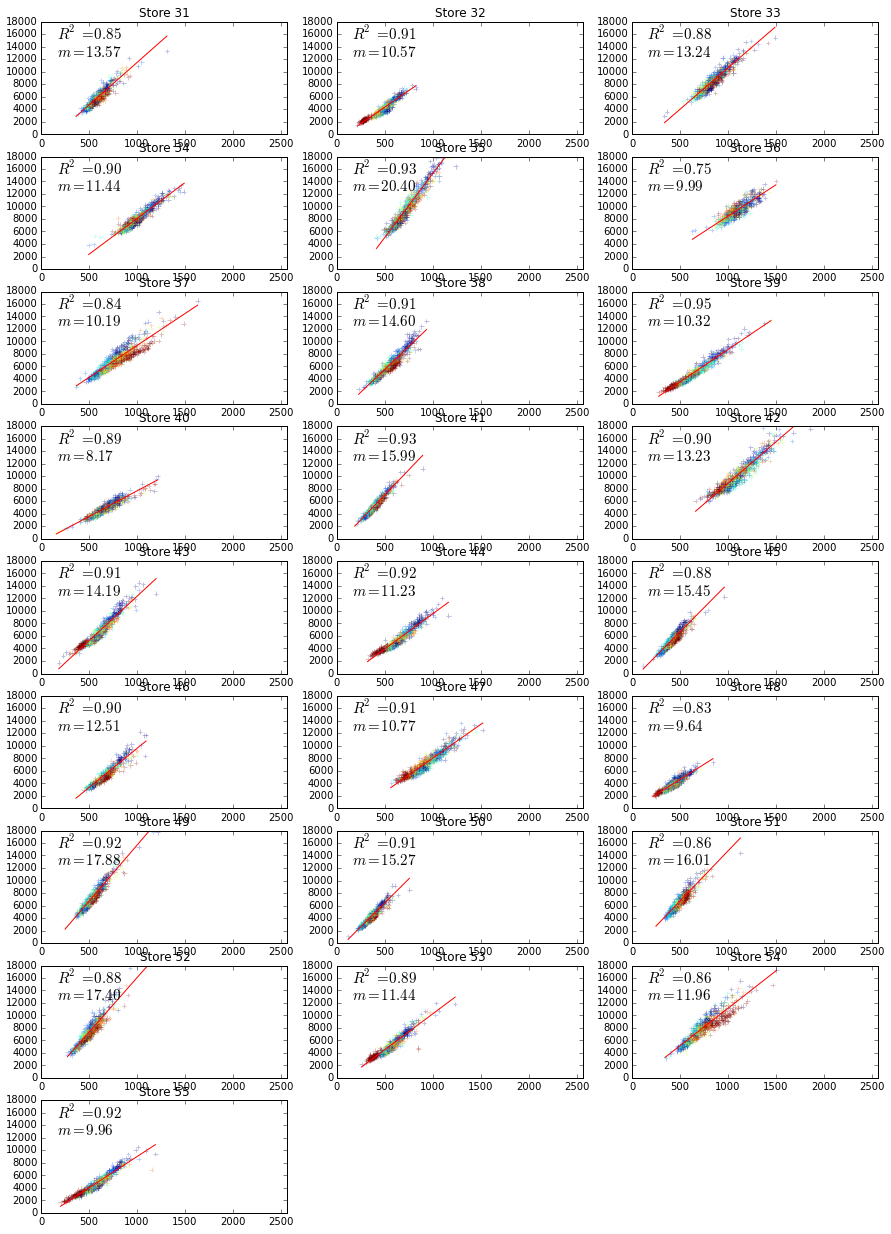

In [41]:
ts = train_data.sort(columns='Date')
#store_df = train_data.loc[train_data['Store'] == store]
plt.figure(figsize=(15,60))
num_plots = 25
starting_store = 31
# set uniform axis so most stores fit in 
Xbound=np.percentile(ts.Customers, 99)
Ybound=np.percentile(ts.Sales, 99)

for i in range(0, num_plots):
    ts1 = ts.loc[ts['Store'] == i + starting_store]
    plot_df = ts1[ts1['Sales'] > 500]
    colors = plot_df.DayOfWeek
    plt.subplot(num_plots, 3, i + 1)
    #plt.axis('off')
    plt.title('Store {0}'.format(starting_store + i))
    plt.scatter(plot_df.Customers, plot_df.Sales, marker= "+", c=colors, alpha=.25)
    plt.axis([0, Xbound+150, 0, Ybound+150])

    #plt.ylabel('Sales')
    #plt.xlabel('customer count')
    
    ## ADD A BEST FIT LINE from - http://stackoverflow.com/questions/22239691/code-for-line-of-best-fit-of-a-scatter-plot-in-python
    xd=plot_df.Customers
    yd=plot_df.Sales
    par = np.polyfit(xd, yd, 1, full=True) # determine best fit line

    slope=par[0][0]
    intercept=par[0][1]
    xl = [min(xd), max(xd)]
    yl = [slope*xx + intercept  for xx in xl]

    # coefficient of determination, plot text
    variance = np.var(yd)
    residuals = np.var([(slope*xx + intercept - yy)  for xx,yy in zip(xd,yd)])
    Rsqr = np.round(1-residuals/variance, decimals=2)
    plt.text(Xbound/15,Ybound*.85,'$R^2 = %0.2f$'% Rsqr, fontsize=15)
    plt.text(Xbound/15,Ybound*.7,'$m = %0.2f$'% slope, fontsize=15)
    plt.plot(xl, yl, '-r')
plt.show()

## add a legend with weekday ##
## scatterplot of sales by day of week## group by store type

# There are store-typical differnence in sales/ customer
# Customer volume is  highly predicive of sales#
* ~.9 R squared and seems relatively stable over time for each store on each day of the week. *

I think we should include the:
historical customer volume x store and 
historical customer volume x day of week
when making predictions.

In [84]:
# GET CUSTOMER X SALES DATA and merge it to the store dataframe

data['Slope'] = np.empty(len(data)) * np.nan
data=train_data
ts = data.sort(columns='Date')

for i in range(1, len(data['Store'].unique())):
    ts1 = data.loc[ts['Store'] == i]
  
    ## get A BEST FIT LINE from - http://stackoverflow.com/questions/22239691/code-for-line-of-best-fit-of-a-scatter-plot-in-python
    xd=ts1.Customers
    yd=ts1.Sales
    par = np.polyfit(xd, yd, 1, full=True) # determine best fit line
    
    # add slope to store data
    slope=par[0][0]
    store_data['Slope'][store_data['Store'] == i]=slope
    
store_data



/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/IPython/kernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Slope
0,1,c,a,1270,9,2008,0,NaN,NaN,NaN,10.081856
1,2,a,a,570,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",9.261548
2,3,a,a,14130,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",12.142351
3,4,c,c,620,9,2009,0,NaN,NaN,NaN,9.328100
4,5,a,a,29910,4,2015,0,NaN,NaN,NaN,10.067051
5,6,a,a,310,12,2013,0,NaN,NaN,NaN,9.476838
6,7,a,c,24000,4,2013,0,NaN,NaN,NaN,10.735506
7,8,a,a,7520,10,2014,0,NaN,NaN,NaN,10.221588
8,9,a,c,2030,8,2000,0,NaN,NaN,NaN,15.215883
9,10,a,a,3160,9,2009,0,NaN,NaN,NaN,11.932337


In [99]:
# MERGE
#For each store, find its first opening day and merge it into store_df

train_by_Store_data = train_data.groupby('Store')
storeOpenDays = train_by_Store_data['Date'].min()
#pd.unique(storeOpenDays)
#storeOpenDays[storeOpenDays != np.datetime64('2013-01-02')]

d = pd.DataFrame(storeOpenDays)
d = d.rename(columns = {'Date':'OpenDay'})
store_data = pd.merge(store_data, d, left_on = 'Store', right_index = True) 


In [100]:
store_data.columns

Index([u'Store', u'StoreType', u'Assortment', u'CompetitionDistance',
       u'CompetitionOpenSinceMonth', u'CompetitionOpenSinceYear', u'Promo2',
       u'Promo2SinceWeek', u'Promo2SinceYear', u'PromoInterval', u'Slope',
       u'OpenDay_x', u'CompetitorOpenDay', u'OpenDay_y', u'OpenDay'],
      dtype='object')

KeyError: 'StoreType'

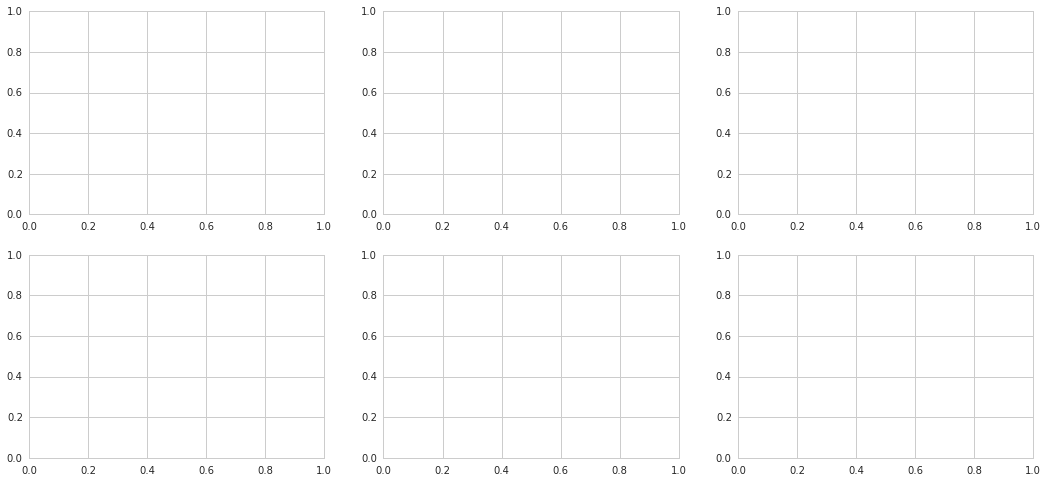

In [101]:
#INSPECT THE SLOPE DATA

# do store sales per customer correspond to 
#store type, 
#Competition distance, 
#assortment, 
#comptetion open since month

fig, ax_list = plt.subplots(2,3, figsize=(18,8))
ax_list = ax_list.ravel()

BoxPlotGroupBy(train_data, 'Slope', 'StoreType', ax_list[0])
#BoxPlotGroupBy(train_data,'Sales', 'StateHoliday', ax_list[1])
#BoxPlotGroupBy(train_data,'Sales', 'Promo', ax_list[2])
#BoxPlotGroupBy(train_data,'Sales', 'SchoolHoliday', ax_list[3])
#BoxPlotGroupBy(train_data,'Sales', 'StoreType', ax_list[4])
#BoxPlotGroupBy(train_data,'Sales', 'Assortment', ax_list[5])
fig.tight_layout()
plt.show()





In [93]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844338 entries, 0 to 1017190
Data columns (total 9 columns):
Store            844338 non-null int64
DayOfWeek        844338 non-null int64
Date             844338 non-null datetime64[ns]
Sales            844338 non-null int64
Customers        844338 non-null int64
Promo            844338 non-null int64
StateHoliday     844338 non-null object
SchoolHoliday    844338 non-null int64
Slope            0 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(6), object(1)
memory usage: 64.4+ MB


<class 'pandas.core.frame.DataFrame'>
Int64Index: 844338 entries, 0 to 1017190
Data columns (total 9 columns):
Store            844338 non-null int64
DayOfWeek        844338 non-null int64
Date             844338 non-null datetime64[ns]
Sales            844338 non-null int64
Customers        844338 non-null int64
Promo            844338 non-null int64
StateHoliday     844338 non-null object
SchoolHoliday    844338 non-null int64
Slope            0 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(6), object(1)
memory usage: 64.4+ MB


#How do variables affect sales in general?

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/seaborn/categorical.py:1613: UserWarning: The boxplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


KeyError: 'StoreType'

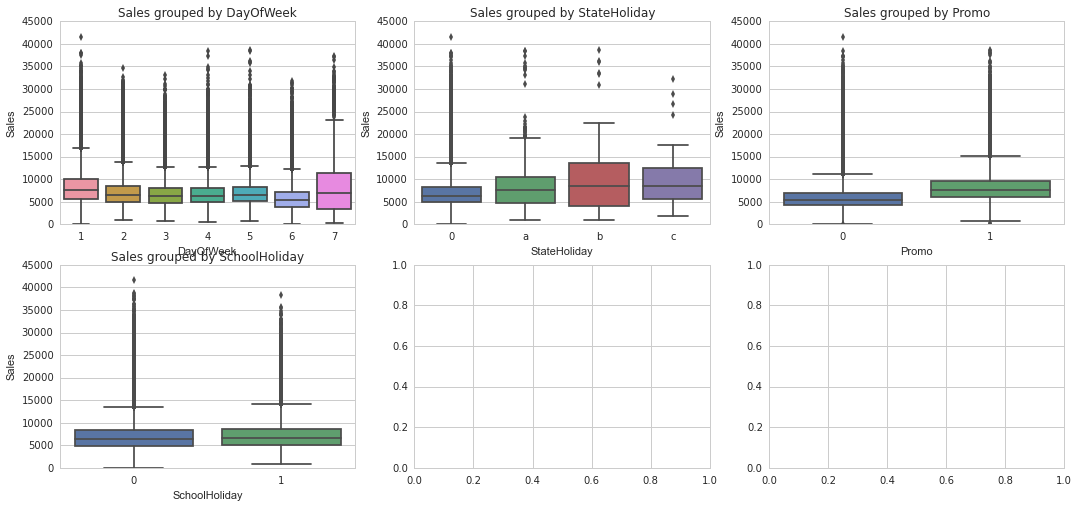

In [92]:
fig, ax_list = plt.subplots(2,3, figsize=(18,8))
ax_list = ax_list.ravel()

BoxPlotGroupBy(train_data, 'Sales', 'DayOfWeek', ax_list[0])
BoxPlotGroupBy(train_data,'Sales', 'StateHoliday', ax_list[1])
BoxPlotGroupBy(train_data,'Sales', 'Promo', ax_list[2])
BoxPlotGroupBy(train_data,'Sales', 'SchoolHoliday', ax_list[3])
BoxPlotGroupBy(train_data,'Sales', 'StoreType', ax_list[4])
BoxPlotGroupBy(train_data,'Sales', 'Assortment', ax_list[5])
fig.tight_layout()
plt.show()

In [ ]:
y = 'Sales'
ax = sns.boxplot(x = 'StateHoliday', y = 'Sales', hue = 'Promo', data = train_df)
ax.set_title("Between StateHoliday and Promo")

In [ ]:
import matplotlib.dates as dates
import matplotlib.dates as mdates
from matplotlib.dates import MonthLocator, WeekdayLocator, DateFormatter

import datetime

def PlotAvgSalesByGroup(group, storeId=None, dim=None, daily=False, marker='o', alpha=0.7, **kwargs):
    stores = [None]
    if type(storeId) is list:
        stores = storeId
    else:
        stores = [storeId]
        
    if dim is None:
        dim = [1, len(stores)]
        
    fig, axises = plt.subplots(dim[0], dim[1], figsize=(15,3 * dim[0]))
    if len(stores) == 1:
        axises = [axises]
    else:
        axises = axises.ravel()

    for store, axis in zip(stores, axises):
        if store is None:
            df = train_df
            title = None
        else:
            df = train_df[train_df['Store'] == store]
            title = 'Store ' + str(store)

        train_df_by_group = df.groupby(group)
        colors = cm.rainbow(np.linspace(0, 1, len(train_df_by_group)))
        labels = []

        if not daily:
            monthly_data = train_df_by_group.resample('M', how='mean')

            for groupItem, c in zip(train_df_by_group.groups.keys(), colors):
                # Note: Here we use .loc instead of .ix, otherwise will have problem if groupItem is an integer, as
                #       df.ix[[0]] will give you the first row instead of the first level of a multi-index df
                ax = monthly_data.loc[[groupItem]].plot(y='Sales', ax=axis, marker=marker,
                         legend=False, label=None, color=c, rot=0, alpha=alpha, **kwargs)

                labels.append(str(group) + " = " + str(groupItem))

            dateRange = pd.date_range(train_df.index.min(), train_df.index.max(), freq='M')
            axis.set_xticks(range(len(dateRange)))
            axis.set_xticklabels(["%d-%02d" % (x.year, x.month) for x in dateRange], rotation=90)
        else:
            for groupItem, c in zip(train_df_by_group.groups.keys(), colors):
                d = train_df_by_group.get_group(groupItem).sort_index()
                ax = axis.plot_date(x=d.index.tolist(), y=d['Sales'].tolist(), color=c, marker=marker, 
                                    alpha=alpha, **kwargs)
                labels.append(str(group) + " = " + str(groupItem))

            axis.xaxis.set_major_locator(MonthLocator(range(1, 13), bymonthday=1, interval=1))
            axis.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
            fig.autofmt_xdate(rotation=90)
            plt.grid(True)

        axis.legend(labels, loc = 2, numpoints = 1)
        if title is not None:
            axis.set_title(title)

In [ ]:
PlotAvgSalesByGroup('Promo')

In [ ]:
PlotAvgSalesByGroup('DayOfWeek')

In [ ]:
PlotAvgSalesByGroup('SchoolHoliday')

In [ ]:
PlotAvgSalesByGroup('StateHoliday', linestyle='None', marker='o', markersize=10, alpha=0.7)

In [ ]:
PlotAvgSalesByGroup('Promo', storeId=range(8,14), dim=[3,2], marker='.',daily=True, linestyle='None', alpha=0.7)

In [ ]:
PlotAvgSalesByGroup('Promo', store=2, marker='.',daily=True, linestyle='None')

In [ ]:
PlotAvgSalesByGroup('StateHoliday', store=839, marker='.',daily=True, linestyle='None')

In [ ]:
PlotAvgSalesByGroup('SchoolHoliday', store=500, marker='.',daily=True, linestyle='None')

In [ ]:
PlotAvgSalesByGroup('Promo', store=13, marker='.',daily=True, linestyle='None')

In [ ]:
PlotAvgSalesByGroup('DayOfWeek', store=12, marker='.',daily=True, linestyle='None')

### Any relationship between Store Attributes and Average Monthly Sales?###

In [ ]:
PlotAvgSalesByGroup('StoreType', alpha=0.7)
PlotAvgSalesByGroup('Assortment')

# 2 - Merge, Check, Summarize - Setup the data for analysis ##

In [34]:
#merge the store information
test_full_data = pd.merge(test_data, store_data.ix[:,['StoreType', 'Assortment', 'Store']], on='Store')
test_data_merge = transformData(test_full_data)
##result = makePredictions(test_data)

train_full_data = pd.merge(train_data, store_data.ix[:,['StoreType', 'Assortment', 'Store']], on='Store')
train_data_merge = transformData(train_full_data)

In [36]:
#Find factor levels in the trianing data
quantLevel(train_data, ['StateHoliday', 'SchoolHoliday', 'Promo'])

StateHoliday
0    0.998922
a    0.000822
b    0.000172
c    0.000084
dtype: float64

SchoolHoliday
0    0.806422
1    0.193578
dtype: float64

Promo
0    0.553644
1    0.446356
dtype: float64



In [37]:
test_data_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35093 entries, 0 to 35092
Data columns (total 25 columns):
Id                 35093 non-null int64
Store              35093 non-null int64
Date               35093 non-null datetime64[ns]
DayOfWeek_1        35093 non-null float64
DayOfWeek_2        35093 non-null float64
DayOfWeek_3        35093 non-null float64
DayOfWeek_4        35093 non-null float64
DayOfWeek_5        35093 non-null float64
DayOfWeek_6        35093 non-null float64
DayOfWeek_7        35093 non-null float64
Promo_0            35093 non-null float64
Promo_1            35093 non-null float64
StateHoliday_0     35093 non-null float64
StateHoliday_a     35093 non-null float64
StateHoliday_b     35093 non-null float64
StateHoliday_c     35093 non-null float64
SchoolHoliday_0    35093 non-null float64
SchoolHoliday_1    35093 non-null float64
StoreType_a        35093 non-null float64
StoreType_b        35093 non-null float64
StoreType_c        35093 non-null float64
StoreT

In [38]:
train_data_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844338 entries, 0 to 844337
Data columns (total 26 columns):
Store              844338 non-null int64
Date               844338 non-null datetime64[ns]
Sales              844338 non-null int64
Customers          844338 non-null int64
DayOfWeek_1        844338 non-null float64
DayOfWeek_2        844338 non-null float64
DayOfWeek_3        844338 non-null float64
DayOfWeek_4        844338 non-null float64
DayOfWeek_5        844338 non-null float64
DayOfWeek_6        844338 non-null float64
DayOfWeek_7        844338 non-null float64
Promo_0            844338 non-null float64
Promo_1            844338 non-null float64
StateHoliday_0     844338 non-null float64
StateHoliday_a     844338 non-null float64
StateHoliday_b     844338 non-null float64
StateHoliday_c     844338 non-null float64
SchoolHoliday_0    844338 non-null float64
SchoolHoliday_1    844338 non-null float64
StoreType_a        844338 non-null float64
StoreType_b        844338 no

In [39]:
store_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1115 entries, 0 to 1114
Data columns (total 10 columns):
Store                        1115 non-null int64
StoreType                    1115 non-null object
Assortment                   1115 non-null object
CompetitionDistance          1112 non-null float64
CompetitionOpenSinceMonth    761 non-null float64
CompetitionOpenSinceYear     761 non-null float64
Promo2                       1115 non-null int64
Promo2SinceWeek              571 non-null float64
Promo2SinceYear              571 non-null float64
PromoInterval                571 non-null object
dtypes: float64(5), int64(2), object(3)
memory usage: 95.8+ KB


In [48]:
train_full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 11 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null int64
Date             1017209 non-null datetime64[ns]
Sales            1017209 non-null int64
Customers        1017209 non-null int64
Open             1017209 non-null int64
Promo            1017209 non-null int64
StateHoliday     1017209 non-null object
SchoolHoliday    1017209 non-null int64
StoreType        1017209 non-null object
Assortment       1017209 non-null object
dtypes: datetime64[ns](1), int64(7), object(3)
memory usage: 93.1+ MB


In [40]:
test_full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35093 entries, 0 to 35092
Data columns (total 9 columns):
Id               35093 non-null int64
Store            35093 non-null int64
DayOfWeek        35093 non-null int64
Date             35093 non-null datetime64[ns]
Promo            35093 non-null int64
StateHoliday     35093 non-null object
SchoolHoliday    35093 non-null int64
StoreType        35093 non-null object
Assortment       35093 non-null object
dtypes: datetime64[ns](1), int64(5), object(3)
memory usage: 2.7+ MB


In [80]:
#store_data['Slope'][store_data[store_data['Store']==10].index]=10
#store_data['Slope'][5]=10
#store_data['Slope'] = np.zeros(len(store_data))
#store_data['Slope'] = np.empty(len(store_data)) * np.nan
#store_data
store_data['Slope'][5]

10.081855625605838

In [92]:
print len(sample_stores)
print dev_test_data.shape
print train_data.shape

111
(87672, 9)
(1017209, 9)


In [18]:
#SUBSET DEV AND TRAINING SET
#sample 20% of the train_data dataframe
sample_stores = random.sample(store_data.index, len(store_data)/20)
dev_train_data = train_data[train_data['Store'].isin(sample_stores)]

# Remove the mini_train data from the train dataframe
train_data = train_data[~train_data['Store'].isin(sample_stores)]

# use 10% for a dev_test data set
#>sample_stores = random.sample(store_data.index, len(store_data)/10)
#>dev_test_data = train_data[train_data['Store'].isin(sample_stores)]
#>train_data = train_data[~train_data['Store'].isin(sample_stores)]

In [ ]:
#Add new features inspired by patrick's exploratoy anaylsis

#total days 

#month

#attribute x total time 

#day of week x month 

#school holiday x month

#state holiday x promo



In [ ]:
#some other ideas 

# total time open

# customer X sales slope



    

In [ ]:
#scale the data

In [26]:
# lets see if test data contains closed stores too
# being closed is probably predictive of zero sales

,Id,Store,DayOfWeek,Open,Promo,SchoolHoliday
count,41088.000000,41088.000000,41088.000000,41077.000000,41088.000000,41088.000000
mean,20544.500000,555.899533,3.979167,0.854322,0.395833,0.443487
std,11861.228267,320.274496,2.015481,0.352787,0.489035,0.496802
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,10272.750000,279.750000,2.000000,1.000000,0.000000,0.000000
50%,20544.500000,553.500000,4.000000,1.000000,0.000000,0.000000
75%,30816.250000,832.250000,6.000000,1.000000,1.000000,1.000000
max,41088.000000,1115.000000,7.000000,1.000000,1.000000,1.000000


# 3-show the models that we tried

# 4-choose a final implementation 